Notebook to see if we can at least replicate the JAHA result

In [1]:
from glob import glob
import pandas as pd
import numpy as np
from nilearn import masking
import os
import matplotlib.pylab as plt

In [2]:
demo_dat = pd.read_spss("../data/PIP_n330_03_26_2019.sav")
mask_img_file = '../data/reslicedER_grey25grey25.nii'
react_dat = pd.read_csv("../data/pip_reactivity_2020.csv")

In [3]:
#subjects = os.listdir("../task-stroop/spm/")
#glob("../task-stroop/spm/*/Stroop")

In [4]:
cond_ml = (demo_dat.filter_n310_MLpaper_training_test_identifier=="Traning") | (demo_dat.filter_n310_MLpaper_training_test_identifier=="Test")
demo_ml = demo_dat[cond_ml]

In [5]:
training_subjects = demo_dat[demo_dat['filter_n310_MLpaper_training_test_identifier']=="Training"]["ePrime.id"].astype(int)
test_subjects = demo_dat[demo_dat['filter_n310_MLpaper_training_test_identifier']=="Test"]["ePrime.id"].astype(int)

In [6]:
training_subjects_exist =  [subj for subj in training_subjects \
                      if os.path.exists("../task-stroop/spm/%d/Stroop/con_0003.nii" % subj)]
test_subjects_exist =  [subj for subj in test_subjects \
                      if os.path.exists("../task-stroop/spm/%d/Stroop/con_0003.nii" % subj)]

In [7]:
print(len(training_subjects_exist))
print(len(test_subjects_exist))

200
103


Create training and test input data

In [8]:
X_train = masking.apply_mask(["../task-stroop/spm/%d/Stroop/con_0003.nii" % subj for subj in training_subjects_exist], 
                             mask_img=mask_img_file)
X_test = masking.apply_mask(["../task-stroop/spm/%d/Stroop/con_0003.nii" % subj for subj in test_subjects_exist], 
                             mask_img=mask_img_file)

In [10]:
X_test.shape

(103, 207584)

In [10]:
#subjects_nilearn = os.listdir("../task-stroop/first-level-nilearn/node")
from nilearn.datasets import fetch_icbm152_brain_gm_mask
mni_gm_mask = "../data/group_level_mask.nii.gz"

In [13]:
from nilearn import image
image.load_img(mni_gm_mask).shape

(61, 73, 65)

In [81]:
os.listdir("../task-stroop/spm")

325

In [71]:
from nilearn.image import load_img

list_maps_nilearn = []
list_maps_spm = []

pattern_nilearn = "../task-stroop/first-level-nilearn/node/sub-%d/cope_inc_con.nii.gz"
pattern_spm = "../task-stroop/spm/%s/Stroop/con_0003.nii"

for subj in react_dat.id.to_numpy():
    
    try:
        cope_file_nilearn =  pattern_nilearn % subj
        cope_file_spm =  pattern_spm % subj
        load_img(cope_file_nilearn)
        load_img(cope_file_spm)
        
        list_maps_nilearn.append(cope_file_nilearn)
        list_maps_spm.append(cope_file_spm)
        #final_subjects_thomas.append(subj)
        
    except:
        print("check %d" % subj)
        
#X_nilearn = np.row_stack(X_nilearn)
#X_spm = np.row_stack(X_spm)

check 1002
check 1005
check 2073
check 2098
check 2108
check 2121
check 3143
check 3251
check 4293
check 6547


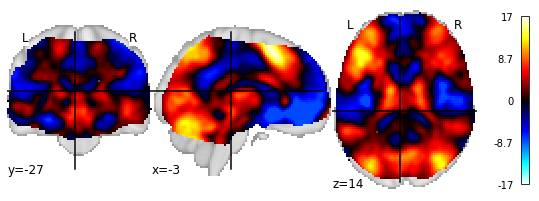

In [72]:
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map

design_matrix = pd.DataFrame({'constant':[1]*len(list_maps_spm)})
second_level = SecondLevelModel()
second_level.fit(list_maps_spm, design_matrix = design_matrix)
plot_stat_map(second_level.compute_contrast('constant'))
#list_maps_spm

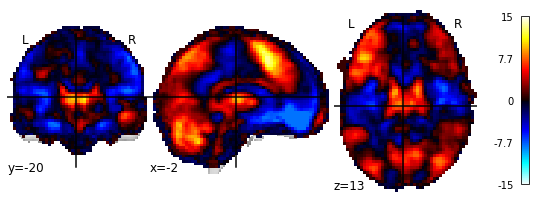

In [70]:
second_level.fit(list_maps_nilearn, design_matrix = design_matrix)
plot_stat_map(second_level.compute_contrast('constant'))

In [73]:
final_subjects_thomas = []
X_nilearn = []
X_spm = []

pattern_nilearn = "../task-stroop/first-level-nilearn/node/sub-%d/cope_inc_con.nii.gz"
pattern_spm = "../task-stroop/spm/%s/Stroop/con_0003.nii"

for subj in react_dat.id.to_numpy():
    
    try:
        cope_file_nilearn =  pattern_nilearn % subj
        cope_file_spm =  pattern_spm % subj
        x_nilearn = masking.apply_mask(cope_file_nilearn, mask_img=mni_gm_mask)
        x_spm = masking.apply_mask(cope_file_spm, mask_img=mask_img_file)
        
        X_nilearn.append(x_nilearn)
        X_spm.append(x_spm)
        final_subjects_thomas.append(subj)
        
    except:
        print("check %d" % subj)
        
X_nilearn = np.row_stack(X_nilearn)
X_spm = np.row_stack(X_spm)

check 1002
check 1005
check 2073
check 2098
check 2108
check 2121
check 3143
check 3251
check 4293
check 6547


In [74]:
print(X_nilearn.shape)
print(X_spm.shape)

(321, 44143)
(321, 207584)


In [75]:
target_var = "sbp_reactivity_stroop"

y = pd.merge(pd.Series(data=final_subjects_thomas, name="id", dtype=float), 
                   react_dat, on="id").loc[:, target_var].to_numpy()
y_bin = np.digitize(y, np.quantile(y, q=np.linspace(0,1,10, endpoint=False)))

fd_mean = pd.merge(pd.Series(data=final_subjects_thomas, name="ePrime.id", dtype=float), 
                   demo_dat, on="ePrime.id").loc[:, "fdmean_thres1_Stroop"].to_numpy()

nans_fd = ~np.isnan(fd_mean)

In [50]:
fd_mean_nan = fd_mean[nans_fd]
X_spm_nan = X_spm[nans_fd]
X_nilearn_nan = X_nilearn[nans_fd]
y_nan = y[nans_fd]
y_bin_nan = y_bin[nans_fd]

In [76]:
# Generate partition
from sklearn.model_selection import train_test_split

X_nilearn_train, X_nilearn_test, X_spm_train, X_spm_test, y_train, y_test, fd_train, fd_test = train_test_split(X_nilearn_nan,
                                                                                                                X_spm_nan,
                                                                                                                y_nan, 
                                                                                                                fd_mean_nan,
                                                                                                                train_size=2/3, 
                                                                                                                shuffle=True, 
                                                                                                                random_state=0, 
                                                                                                                stratify=y_bin_nan)
from scipy.stats import ks_2samp
ks_2samp(y_train, y_test)

KstestResult(statistic=0.06949676422293055, pvalue=0.8705967646169355)

In [48]:
#X_train_nilearn = masking.apply_mask(["../task-stroop/first-level-nilearn/node/sub-%d/cope_inc_con.nii.gz" % subj for subj in training_subjects_exist], 
 #                            mask_img=mask_img_file)
#X_test_nilearn = masking.apply_mask(["../task-stroop/first-level-nilearn/node/sub-%d/cope_inc_con.nii.gz" % subj for subj in test_subjects_exist], 
 #                            mask_img=mask_img_file)

Create traning and test target/response data with the new reactivity info

In [89]:
#target_var = "sbp_reactivity_stroop"

#y_train = pd.merge(pd.Series(data=training_subjects_exist, name="id", dtype=float), 
 #                  react_dat, on="id").loc[:, target_var].to_numpy()

#y_test = pd.merge(pd.Series(data=test_subjects_exist, name="id", dtype=float), 
 #                  react_dat, on="id").loc[:, target_var].to_numpy()

In [13]:
from scipy.stats import ks_2samp
ks_2samp(y_train, y_test)

KstestResult(statistic=0.04989615031637927, pvalue=0.9914897029579841)

# ML PREDICTION

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, LinearRegression, LassoLarsCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [53]:
from my_sklearn_tools.pca_regressors import PCARegressionCV
from my_sklearn_tools.model_selection import StratifiedKFoldReg

cv_inner = StratifiedKFoldReg(n_splits=10, shuffle=True, random_state=0)

#lasso_pcr = PCARegressionCV(scale=False, cv=cv_inner).build(reg_type='lasso')

In [41]:
lasso_pcr

GridSearchCV(cv=StratifiedKFoldReg(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(memory=Memory(location=/tmp/tmpydrjm4jt/joblib),
                                steps=[('variancethreshold',
                                        VarianceThreshold()),
                                       ('pca', PCA()),
                                       ('lasso', Lasso(max_iter=1000000.0))]),
             param_grid={'lasso__alpha': array([1.00000000e-04, 1.14975700e-04, 1.32194115e-04, 1.51991108e-04,
       1.74752840e-...
       4.03701726e+00, 4.64158883e+00, 5.33669923e+00, 6.13590727e+00,
       7.05480231e+00, 8.11130831e+00, 9.32603347e+00, 1.07226722e+01,
       1.23284674e+01, 1.41747416e+01, 1.62975083e+01, 1.87381742e+01,
       2.15443469e+01, 2.47707636e+01, 2.84803587e+01, 3.27454916e+01,
       3.76493581e+01, 4.32876128e+01, 4.97702356e+01, 5.72236766e+01,
       6.57933225e+01, 7.56463328e+01, 8.69749003e+01, 1.00000000e+02])},
             scorin

In [77]:
#cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0).split(np.zeros(len(y_train_bin)), y_train_bin)
#pip = make_pipeline(StandardScaler(), PCA(), LassoLarsCV(cv=cv, max_iter=1e6))
pip = make_pipeline(VarianceThreshold(), PCA(), LassoCV(cv=cv_inner, n_alphas=1000, max_iter=1e6))
#pip = make_pipeline(VarianceThreshold(), StandardScaler(), PCA(), LinearRegression())

In [78]:
for ii in range(10):
    X_spm_train, X_spm_test, y_train, y_test = train_test_split(X_spm, y, train_size=2/3, shuffle=True, random_state=ii, stratify=y_bin)
    pip.fit(X_spm_train, y_train)
    print(np.corrcoef(y_test, pip.predict(X_spm_test))[0,1])
    print(r2_score(y_test, pip.predict(X_spm_test)))

0.008639367268428335
-0.026433379609692276


/home/javi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/javi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


nan
-0.002885769728520504
0.2029753556311277
0.04005897685396009


/home/javi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/javi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


nan
-0.002564331178913415
0.032830347762362204
-0.002322782478502594


/home/javi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/javi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


nan
-0.0004112474176138914
0.19547750070592176
0.030725369325230623
0.012175497346899046
-0.001267527982620864


/home/javi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/javi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


nan
-0.004556411386843262
-0.20565030862999611
-0.04058234155181317


In [79]:
for ii in range(10):
    X_nilearn_train, X_nilearn_test, y_train, y_test = train_test_split(X_nilearn, y, train_size=2/3, shuffle=True, random_state=ii, stratify=y_bin)
    pip.fit(X_nilearn_train, y_train)
    print(np.corrcoef(y_test, pip.predict(X_nilearn_test))[0,1])
    print(r2_score(y_test, pip.predict(X_nilearn_test)))

0.029827138158794834
-0.0022123067985111433
-0.019746983120021388
-0.011077956434881964


/home/javi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/javi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


nan
-0.00048467795555517945
-0.056888263477892664
-0.002564335177984489
-0.12399431602533663
-0.08871045053822946
-0.06549037355822375
-0.00572381636155983
-0.1847714738881029
-0.07936207803739936
-0.1430835850845628
-0.00048666083903792234
-2.0136594531844653e-16
-0.00455641049391442
0.016435134405036782
-0.006806838788802949


In [35]:
y_pred_spm = pip.predict(X_spm_test)

In [39]:
np.corrcoef(y_test[~np.isnan(fd_test)], fd_test[~np.isnan(fd_test)])

array([[ 1.      , -0.177437],
       [-0.177437,  1.      ]])

In [ ]:
np.corrcoef(y_test[~np.isnan(fd_test)], fd_test[~np.isnan(fd_test)])

(array([ 1.,  0.,  1.,  8., 18., 38., 26., 10.,  3.,  3.]),
 array([-24.33333333, -19.23333333, -14.13333333,  -9.03333333,
         -3.93333333,   1.16666667,   6.26666667,  11.36666667,
         16.46666667,  21.56666667,  26.66666667]),
 <BarContainer object of 10 artists>)

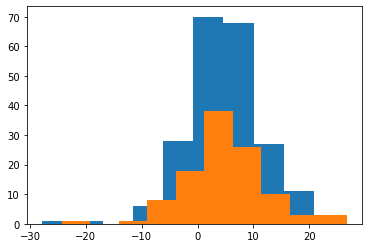

In [35]:
plt.hist(y_train)
plt.hist(y_test)

In [65]:
mask_img_file

'../data/reslicedER_grey25grey25.nii'

In [73]:
"../task-stroop/spm/1003/Stroop/"

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]

In [75]:
X_spm = []
subjects_spm = []
pattern_spm = "../task-stroop/spm/%s/Stroop/con_0001.nii"
for subj in [name.split("-")[1] for name in subjects_nilearn]:
    
    try:
        X = masking.apply_mask(pattern_spm % subj,mask_img=mask_img_file)
        X_spm.append(X)
        subjects_spm.append(subj)
    except:
        print("no %s" % subj)       

no 6539
no 6492
no 6516
no 7559
no 3222
no 2121
no 6473
no 4284
no 325
no 5315
no 1002
no 3134


In [76]:
X_spm= np.row_stack(X_spm)
X_spm.shape

(321, 207584)

In [ ]:
#X_stroop_spm = subjects_nilearn

In [62]:
pip.fit(X_train, y_train)

Pipeline(steps=[('variancethreshold', VarianceThreshold()), ('pca', PCA()),
                ('lassocv',
                 LassoCV(cv=StratifiedKFoldReg(n_splits=10, random_state=0, shuffle=True),
                         max_iter=1000000.0, n_alphas=1000))])

In [33]:
pip.fit(X_train, y_train)

Pipeline(steps=[('variancethreshold', VarianceThreshold()),
                ('standardscaler', StandardScaler()), ('pca', PCA()),
                ('lassocv',
                 LassoCV(cv=StratifiedKFoldReg(n_splits=10, random_state=0, shuffle=True),
                         max_iter=1000000.0, n_alphas=1000))])

In [63]:
pip.predict(X_test)

array([4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104651,
       4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104651,
       4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104651,
       4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104651,
       4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104651,
       4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104651,
       4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104651,
       4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104651,
       4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104651,
       4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104651,
       4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104651,
       4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104651,
       4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104651,
       4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104651,
       4.11104651, 4.11104651, 4.11104651, 4.11104651, 4.11104

In [96]:
X_test.shape

(108, 44143)

In [94]:
np.corrcoef(pip.predict(X_test), y_test)

array([[ 1.        , -0.14477905],
       [-0.14477905,  1.        ]])

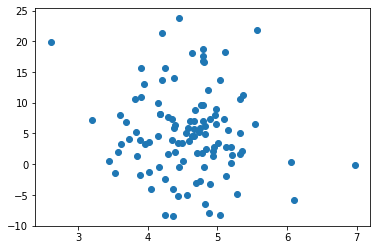

In [73]:
plt.scatter(pip.predict(X_test), y_test)